This notebook contains Inverse mapping of ML models benchmarking with the simulated data.

Lets start with importing all the dependencies.

In [5]:
# Importing all dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Depending on the number of slices in the dataset, choose N = 20 or 40.

Input parameters (emission time, spot size, gun phase and solenoid strength) and all output parameters (z, eps, ksi and d) are combined in one data frame.


In [6]:
#change 20 or 40 slices
N = 40 

# Adjust the relative path according to your notebook's location.
folder_path = os.path.abspath(os.path.join("..", "data", "benchmarking"))
data_in_path = os.path.join(folder_path, f"simulation_input_n{N}.csv")
data_out_path = os.path.join(folder_path, f"simulation_output_n{N}.csv")

# Load the CSV files
data_in = pd.read_csv(data_in_path, delimiter=" ")
data_out = pd.read_csv(data_out_path, delimiter=" ")

# Concatenate data_in and data_out along columns
df = pd.concat([data_in, data_out], axis=1)
df = df.dropna()

#Reset indices, is it mecessary?
#df = df.reset_index(drop=True)

All input and output parameters are now stored in the data fame "df".

To ensure uniformity, we normalize the data by dividing each column's values by its maximum, scaling them between 0 and 1.

However, this scales gun_phase from -1 to 1. To shift it to a 0-1 range, we add 1 to each value and divide by 2.

In [8]:
# normalize with max()

df = df/df.max()
df["gun_phase"] = (df["gun_phase"] + 1) / 2
#print(df)

Preparing the data set for test train split.

In [9]:
# Load and preprocess data, split Train/Test sets
X = df.filter(regex='^(eps|ksi|z|d)_.*$')  # Input: emittance
 
y = df[['emission_time', 'spot_size', 'gun_phase', 'solenoid_strength']]  # Target: configurations

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

TTo visualize the predicted system configurations across all emittance values, we compute a weighted average for each parameter (z, eps, ksi), using charge density as the weight. The weights are determined by normalizing the distance-based values (d_i) within each test sample, ensuring a consistent influence of each data point in the final weighted averages.

When calculating the weights, N= number of slices, as defined before.

In [10]:
### TEST SET WEIGHTED AVG
# Adding columns for outputs with weighted averages in Test set
weighted=[]
weighted=pd.DataFrame(weighted)


N = 40  

# Filter columns dynamically based on N
d_values = X_test.filter(regex='d_.*')
weights_df = pd.DataFrame()

# Calculate weights dynamically for any N
for i in range(1, N + 1):
    weight_col_name = f"W_{i}"
    weights_df[weight_col_name] = d_values[f"d_{i}"] / d_values[[f"d_{i}" for i in range(1, N + 1)]].max(axis=1)

# Calculate weighted averages for z, eps, ksi dynamically
for prefix in ["z", "eps", "ksi"]:
    weighted_sum = sum(X_test[f"{prefix}_{i}"] * weights_df[f"W_{i}"] for i in range(1, N + 1))
    weight_sum = sum(weights_df[f"W_{i}"] for i in range(1, N + 1))
    
    weighted[f"weighted_{prefix}"] = weighted_sum / weight_sum
#print(weighted)

Now we start training all the models and visualise the predicted configutations against weighted emittance.

In [12]:
# Use MultiOutputRegressor with Random Forest
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=6))

# Train the model
model.fit(X_train, y_train)

# Predict
y_pred_rf = model.predict(X_test)

# Evaluate
mse_rf = mean_squared_error(y_test, y_pred_rf, multioutput='raw_values')
print(f"Mean Squared Errors per output: {mse_rf}")

Mean Squared Errors per output: [2.02964225e-04 9.29778396e-05 1.38849416e-03 2.48019989e-04]


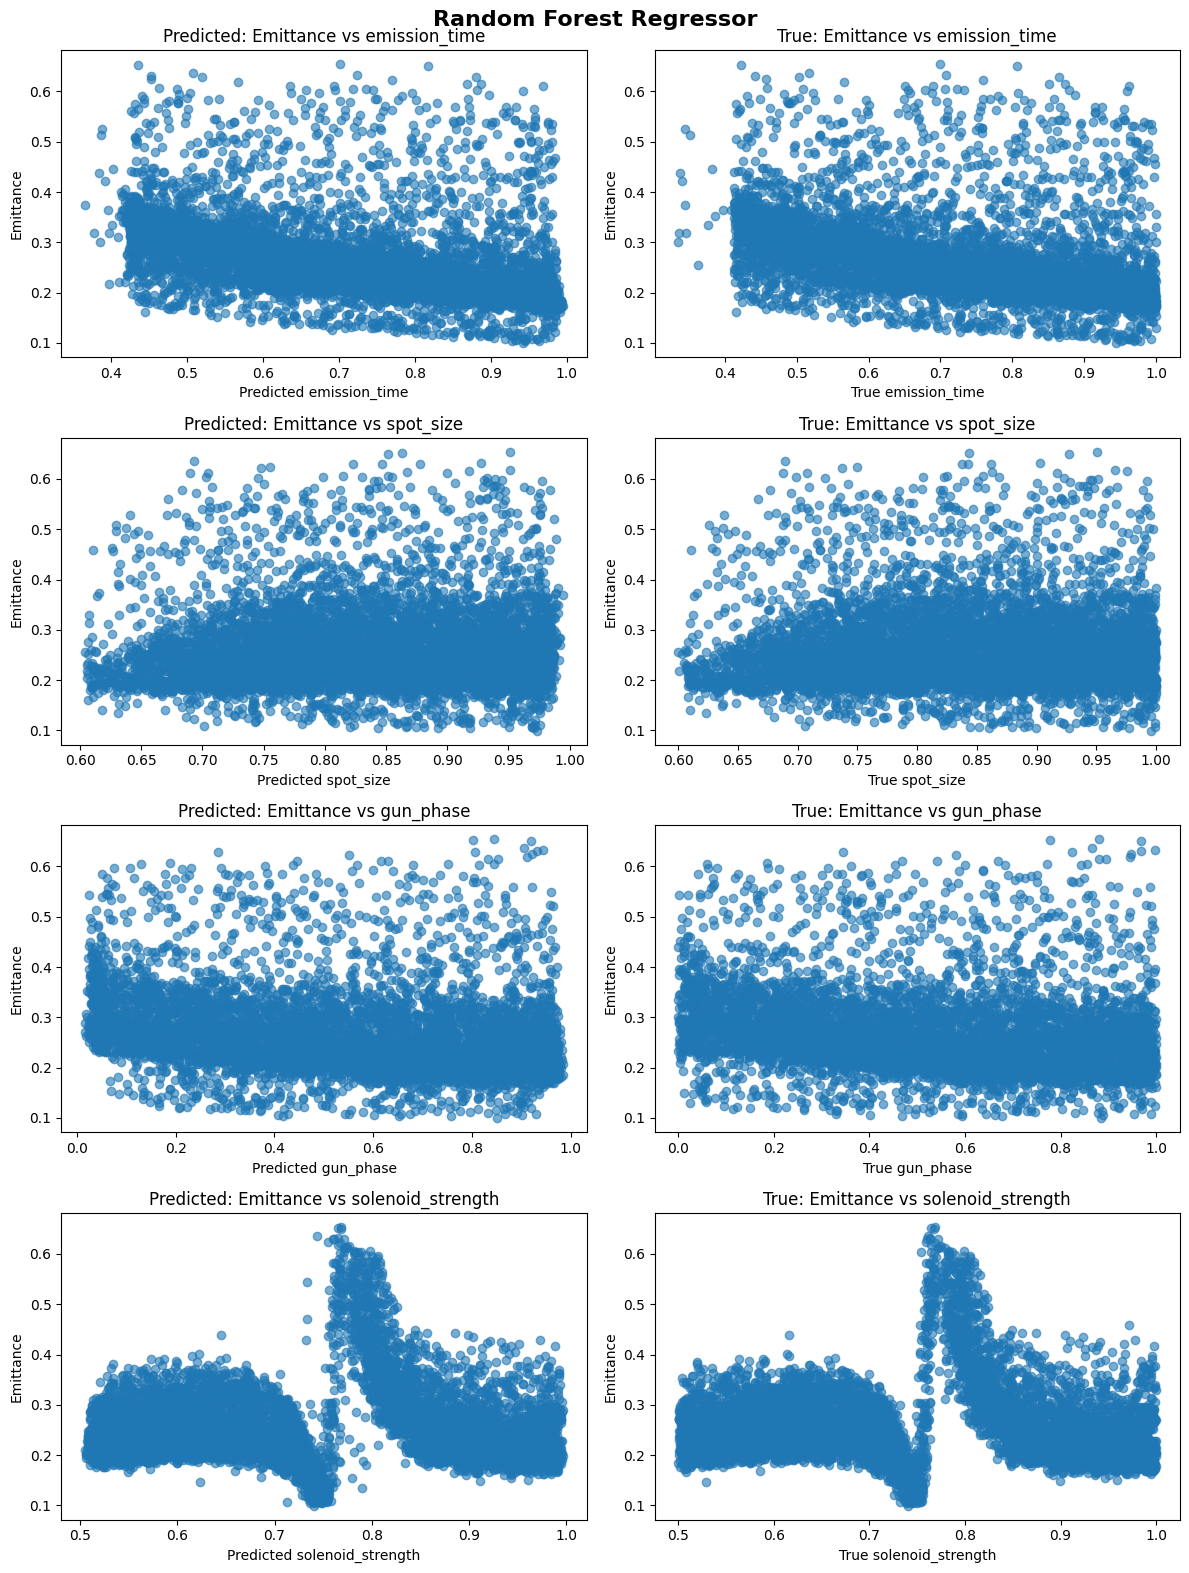

In [13]:
# Define target variables
target_variables = ['emission_time', 'spot_size', 'gun_phase', 'solenoid_strength']

# Create a figure with subplots (4 rows, 2 columns)
fig, axes = plt.subplots(4, 2, figsize=(12, 16))  # Adjust figure size if needed
fig.suptitle("Random Forest Regressor", fontsize=16, fontweight="bold", y=0.98)

# Loop over the target variables
for i, target in enumerate(target_variables):
    # Predicted values (left column)
    axes[i, 0].scatter(y_pred_rf[:, i], weighted["weighted_eps"], alpha=0.6)
    axes[i, 0].set_title(f'Predicted: Emittance vs {target}')
    axes[i, 0].set_xlabel(f'Predicted {target}')
    axes[i, 0].set_ylabel('Emittance')

    # True values (right column)
    axes[i, 1].scatter(y_test[target], weighted["weighted_eps"], alpha=0.6)
    axes[i, 1].set_title(f'True: Emittance vs {target}')
    axes[i, 1].set_xlabel(f'True {target}')
    axes[i, 1].set_ylabel('Emittance')

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()

In [14]:
model = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=100,random_state=42, n_jobs=6))
model.fit(X_train, y_train)
y_pred_et = model.predict(X_test)


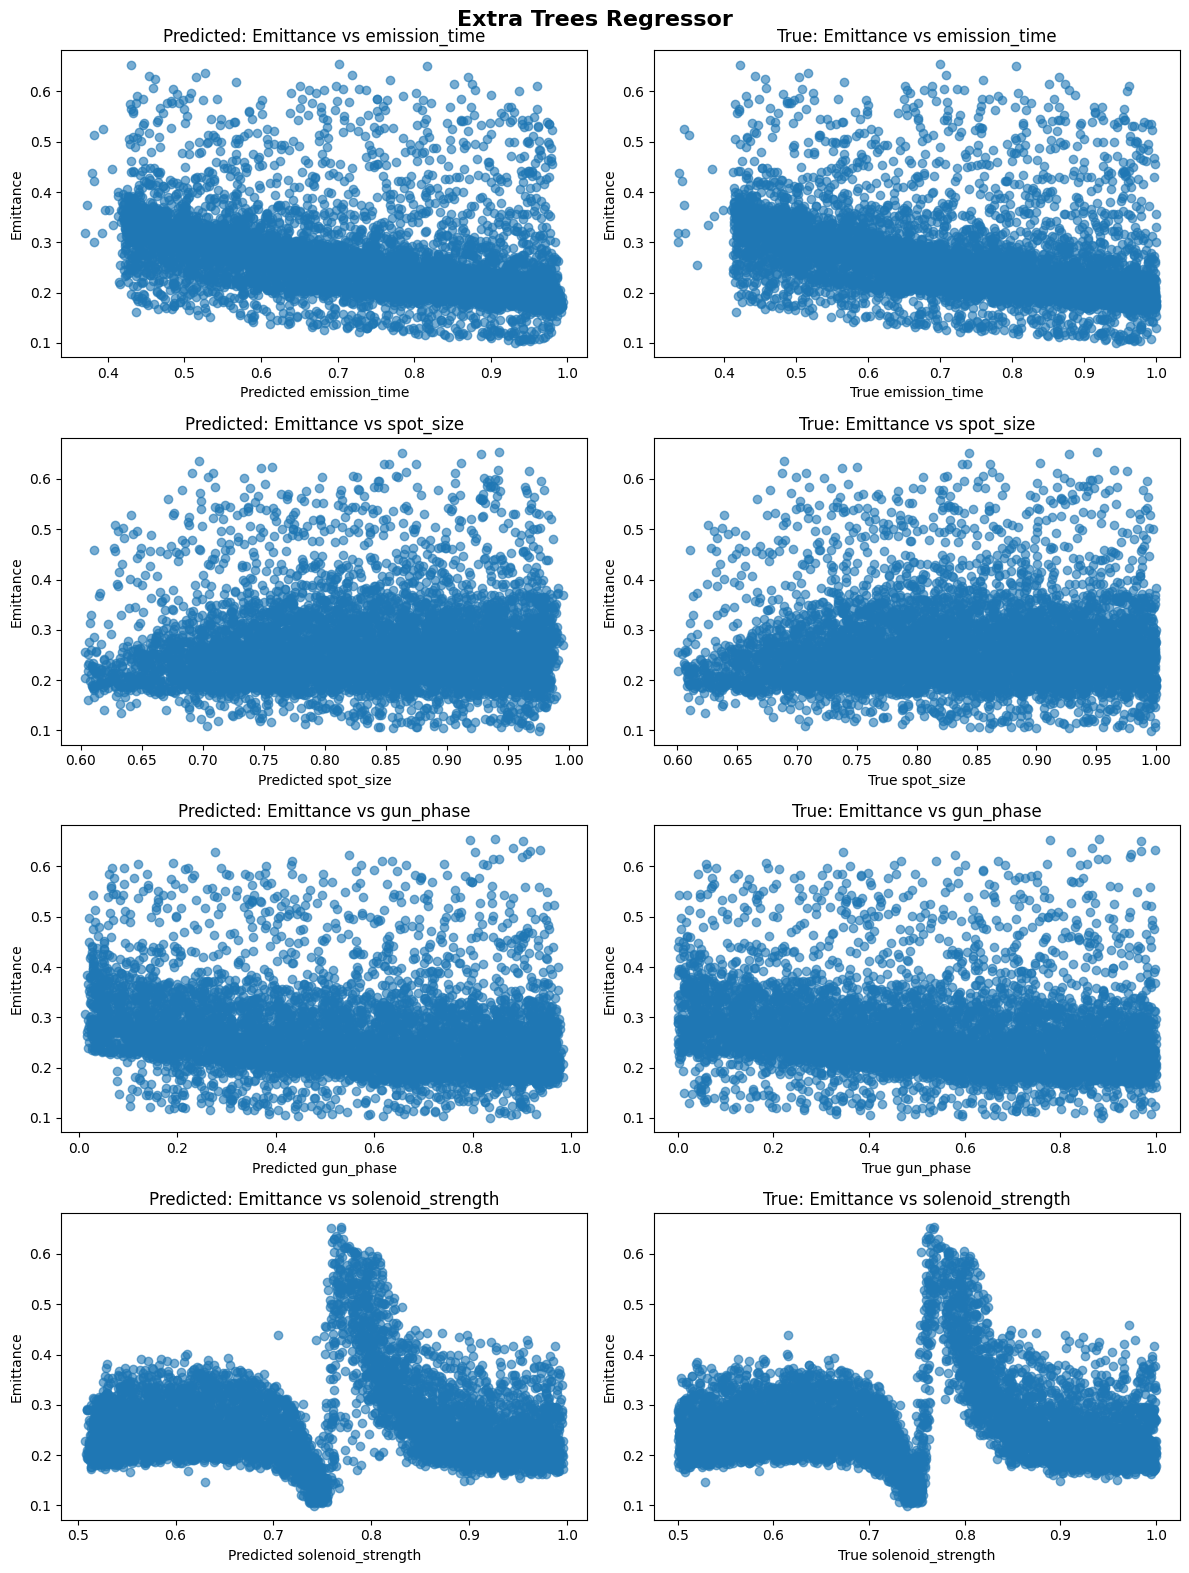

In [15]:
# Define target variables
target_variables = ['emission_time', 'spot_size', 'gun_phase', 'solenoid_strength']

# Create a figure with subplots (4 rows, 2 columns)
fig, axes = plt.subplots(4, 2, figsize=(12, 16))  # Adjust figure size if needed
fig.suptitle("Extra Trees Regressor", fontsize=16, fontweight="bold", y=0.98)

# Loop over the target variables
for i, target in enumerate(target_variables):
    # Predicted values (left column)
    axes[i, 0].scatter(y_pred_et[:, i], weighted["weighted_eps"], alpha=0.6)
    axes[i, 0].set_title(f'Predicted: Emittance vs {target}')
    axes[i, 0].set_xlabel(f'Predicted {target}')
    axes[i, 0].set_ylabel('Emittance')

    # True values (right column)
    axes[i, 1].scatter(y_test[target], weighted["weighted_eps"], alpha=0.6)
    axes[i, 1].set_title(f'True: Emittance vs {target}')
    axes[i, 1].set_xlabel(f'True {target}')
    axes[i, 1].set_ylabel('Emittance')

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()

In [17]:
# Use MultiOutputRegressor with Gradient Boosting
model = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, random_state=42))

# Train the model
model.fit(X_train, y_train)

# Predict
y_pred_gb = model.predict(X_test)

# Evaluate
mse_gb = mean_squared_error(y_test, y_pred_gb, multioutput='raw_values')
print(f"Mean Squared Errors per output: {mse_gb}")


Mean Squared Errors per output: [0.00058092 0.00025653 0.00517957 0.00141687]


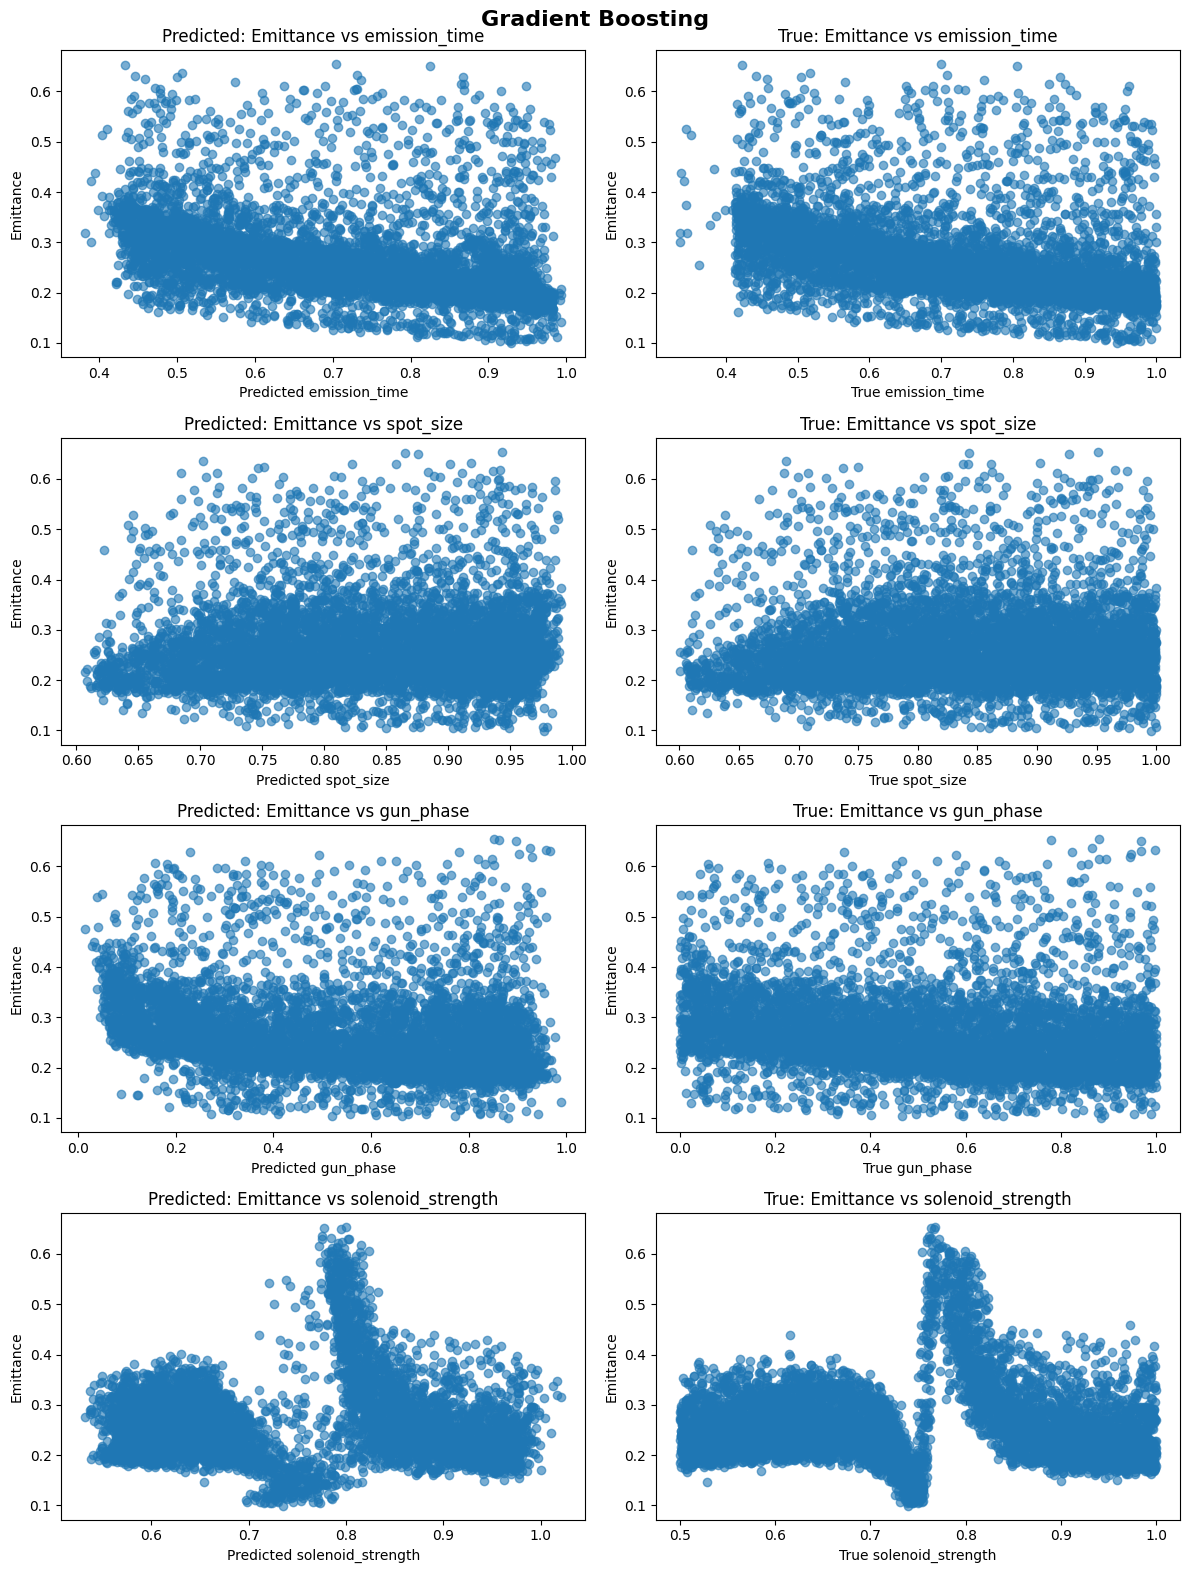

In [18]:
#Visualize
# Define target variables
target_variables = ['emission_time', 'spot_size', 'gun_phase', 'solenoid_strength']

# Create a figure with subplots (4 rows, 2 columns)
fig, axes = plt.subplots(4, 2, figsize=(12, 16))  # Adjust figure size if needed
fig.suptitle("Gradient Boosting", fontsize=16, fontweight="bold", y=0.98)

# Loop over the target variables
for i, target in enumerate(target_variables):
    # Predicted values (left column)
    axes[i, 0].scatter(y_pred_gb[:, i], weighted["weighted_eps"], alpha=0.6)
    axes[i, 0].set_title(f'Predicted: Emittance vs {target}')
    axes[i, 0].set_xlabel(f'Predicted {target}')
    axes[i, 0].set_ylabel('Emittance')

    # True values (right column)
    axes[i, 1].scatter(y_test[target], weighted["weighted_eps"], alpha=0.6)
    axes[i, 1].set_title(f'True: Emittance vs {target}')
    axes[i, 1].set_xlabel(f'True {target}')
    axes[i, 1].set_ylabel('Emittance')

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()

In [19]:
model = MultiOutputRegressor(XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
model.fit(X_train, y_train)
y_pred_xgb = model.predict(X_test)


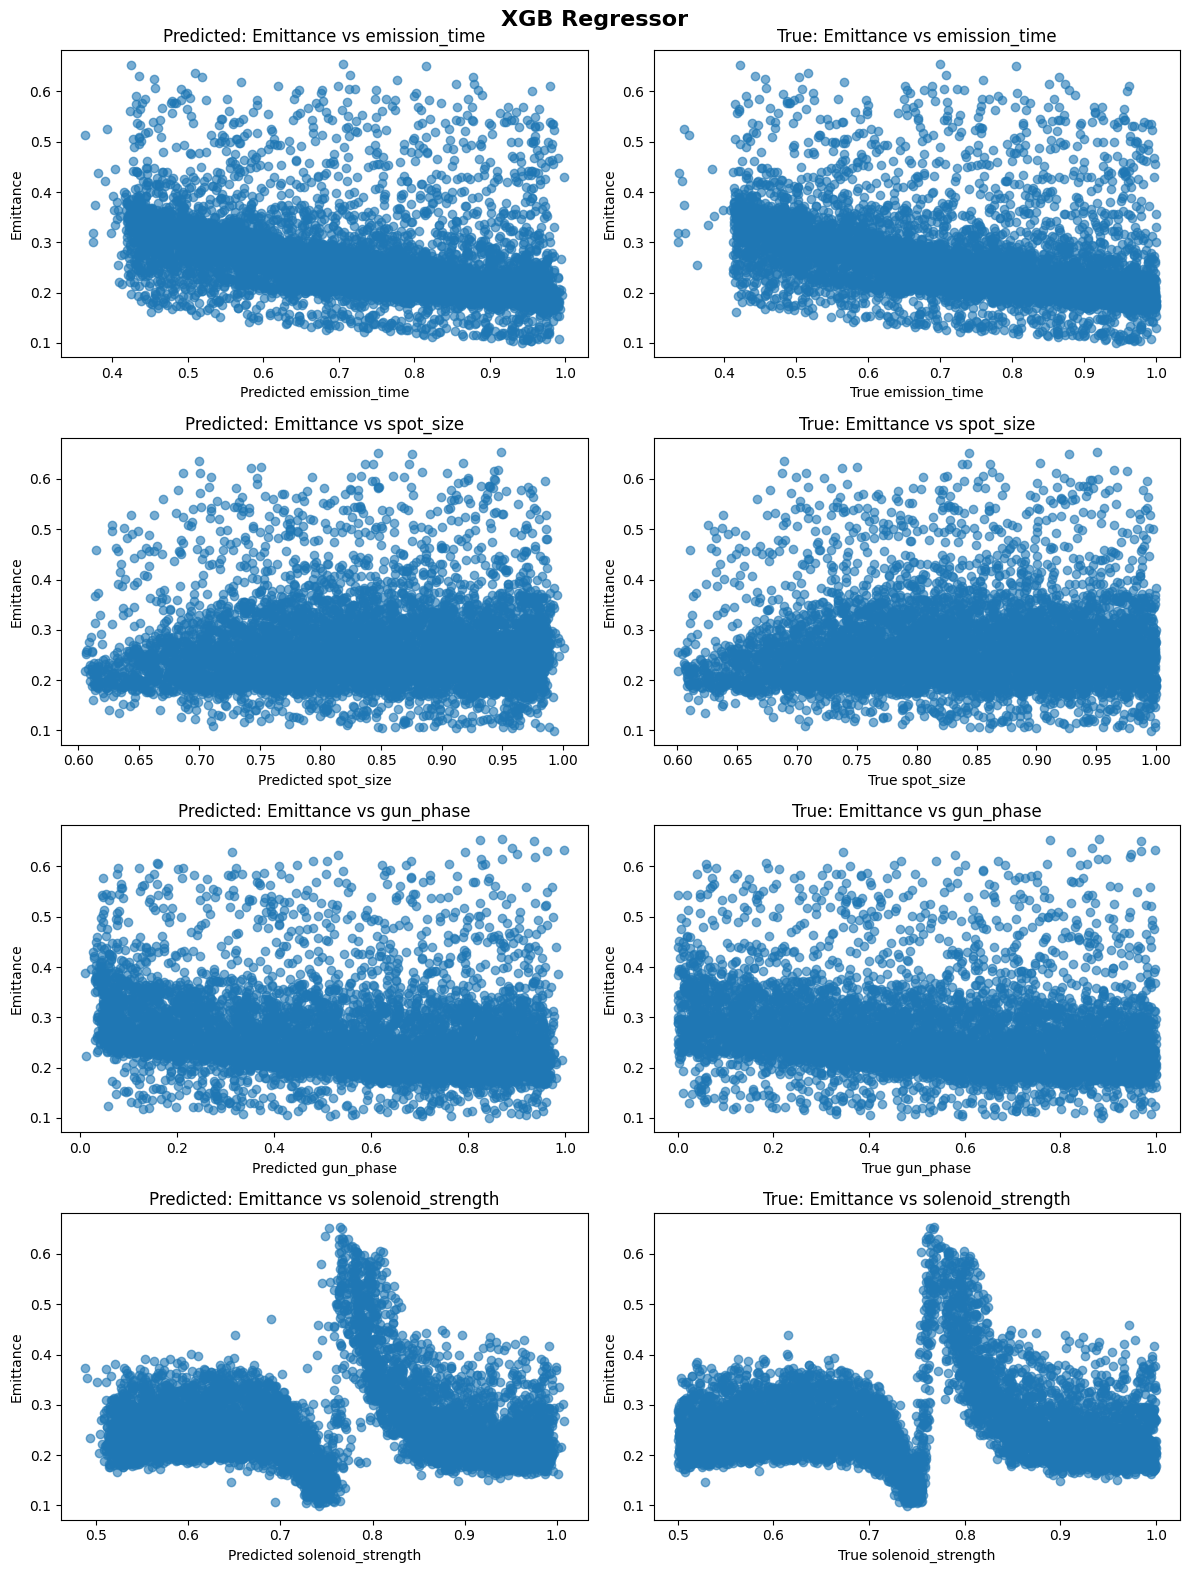

In [20]:
# Define target variables
target_variables = ['emission_time', 'spot_size', 'gun_phase', 'solenoid_strength']

# Create a figure with subplots (4 rows, 2 columns)
fig, axes = plt.subplots(4, 2, figsize=(12, 16))  # Adjust figure size if needed
fig.suptitle("XGB Regressor", fontsize=16, fontweight="bold", y=0.98)

# Loop over the target variables
for i, target in enumerate(target_variables):
    # Predicted values (left column)
    axes[i, 0].scatter(y_pred_xgb[:, i], weighted["weighted_eps"], alpha=0.6)
    axes[i, 0].set_title(f'Predicted: Emittance vs {target}')
    axes[i, 0].set_xlabel(f'Predicted {target}')
    axes[i, 0].set_ylabel('Emittance')

    # True values (right column)
    axes[i, 1].scatter(y_test[target], weighted["weighted_eps"], alpha=0.6)
    axes[i, 1].set_title(f'True: Emittance vs {target}')
    axes[i, 1].set_xlabel(f'True {target}')
    axes[i, 1].set_ylabel('Emittance')

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()

In [21]:
model = MultiOutputRegressor(LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
model.fit(X_train, y_train)
y_pred_lgbm = model.predict(X_test)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40800
[LightGBM] [Info] Number of data points in the train set: 25003, number of used features: 160
[LightGBM] [Info] Start training from score 0.723867
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40800
[LightGBM] [Info] Number of data points in the train set: 25003, number of used features: 160
[LightGBM] [Info] Start training from score 0.832710
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40800
[LightGBM] [Info] Number of data points in the train set: 25003, number of used features: 160
[LightGBM] [Info] Sta

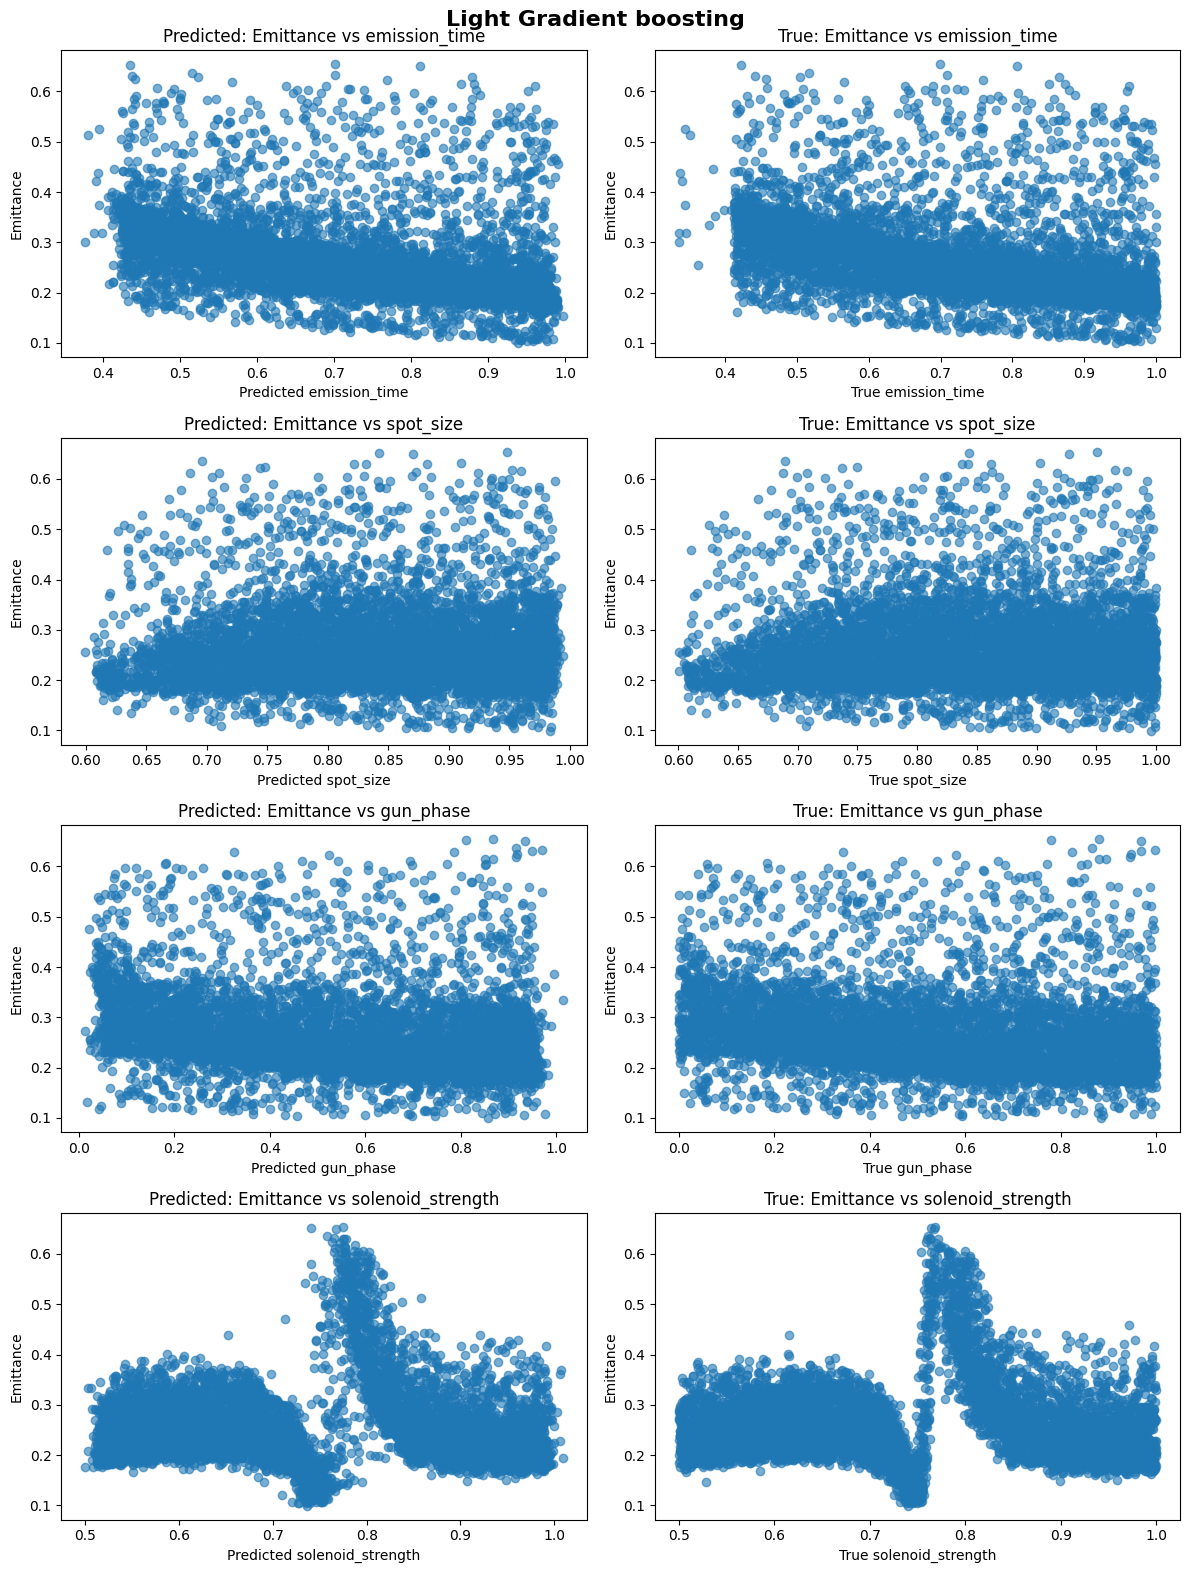

In [22]:
# Define target variables
target_variables = ['emission_time', 'spot_size', 'gun_phase', 'solenoid_strength']

# Create a figure with subplots (4 rows, 2 columns)
fig, axes = plt.subplots(4, 2, figsize=(12, 16))  # Adjust figure size if needed
fig.suptitle("Light Gradient boosting", fontsize=16, fontweight="bold", y=0.98)

# Loop over the target variables
for i, target in enumerate(target_variables):
    # Predicted values (left column)
    axes[i, 0].scatter(y_pred_lgbm[:, i], weighted["weighted_eps"], alpha=0.6)
    axes[i, 0].set_title(f'Predicted: Emittance vs {target}')
    axes[i, 0].set_xlabel(f'Predicted {target}')
    axes[i, 0].set_ylabel('Emittance')

    # True values (right column)
    axes[i, 1].scatter(y_test[target], weighted["weighted_eps"], alpha=0.6)
    axes[i, 1].set_title(f'True: Emittance vs {target}')
    axes[i, 1].set_xlabel(f'True {target}')
    axes[i, 1].set_ylabel('Emittance')

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()

In [23]:
model = MultiOutputRegressor(SVR(kernel='rbf', C=100, gamma=0.1))
model.fit(X_train, y_train)
y_pred_svr = model.predict(X_test)


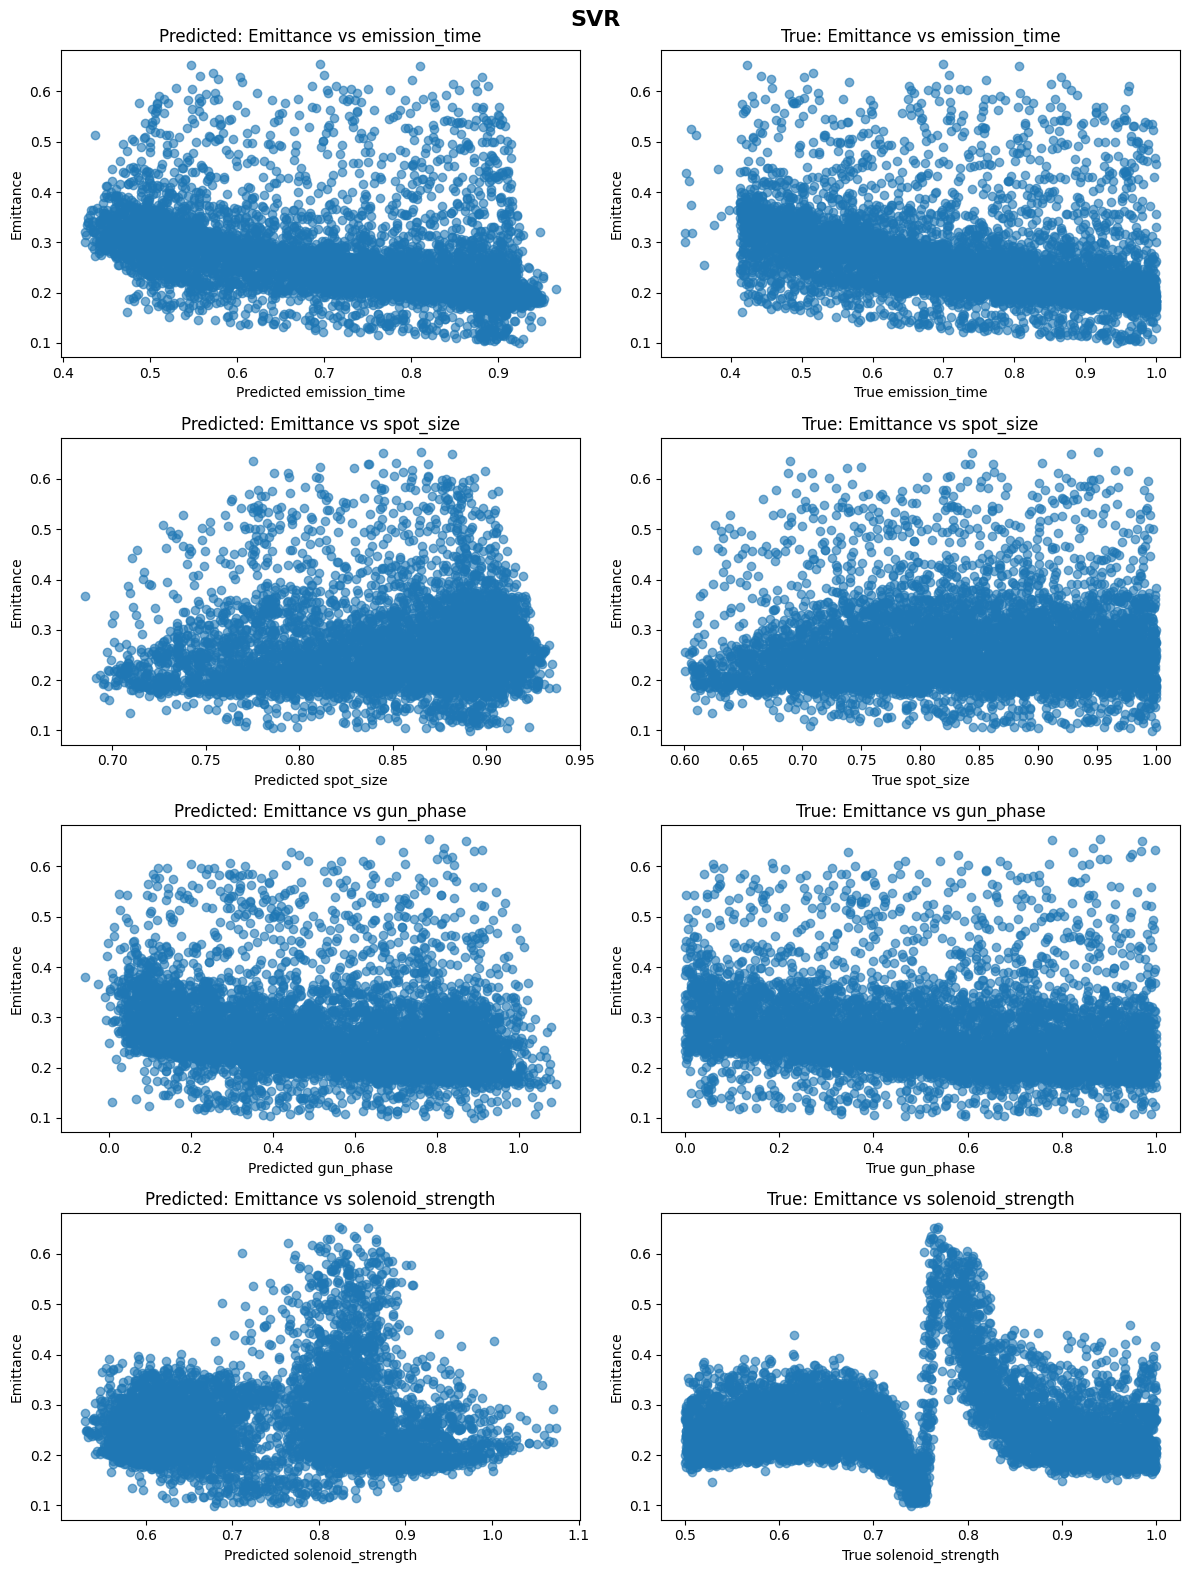

In [24]:
# Define target variables
target_variables = ['emission_time', 'spot_size', 'gun_phase', 'solenoid_strength']

# Create a figure with subplots (4 rows, 2 columns)
fig, axes = plt.subplots(4, 2, figsize=(12, 16))  # Adjust figure size if needed
fig.suptitle("SVR", fontsize=16, fontweight="bold", y=0.98)
# Loop over the target variables
for i, target in enumerate(target_variables):
    # Predicted values (left column)
    axes[i, 0].scatter(y_pred_svr[:, i], weighted["weighted_eps"], alpha=0.6)
    axes[i, 0].set_title(f'Predicted: Emittance vs {target}')
    axes[i, 0].set_xlabel(f'Predicted {target}')
    axes[i, 0].set_ylabel('Emittance')

    # True values (right column)
    axes[i, 1].scatter(y_test[target], weighted["weighted_eps"], alpha=0.6)
    axes[i, 1].set_title(f'True: Emittance vs {target}')
    axes[i, 1].set_xlabel(f'True {target}')
    axes[i, 1].set_ylabel('Emittance')

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()

In [25]:
model = MultiOutputRegressor(MLPRegressor(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', max_iter=1000))
model.fit(X_train, y_train)
y_pred_mlp = model.predict(X_test)


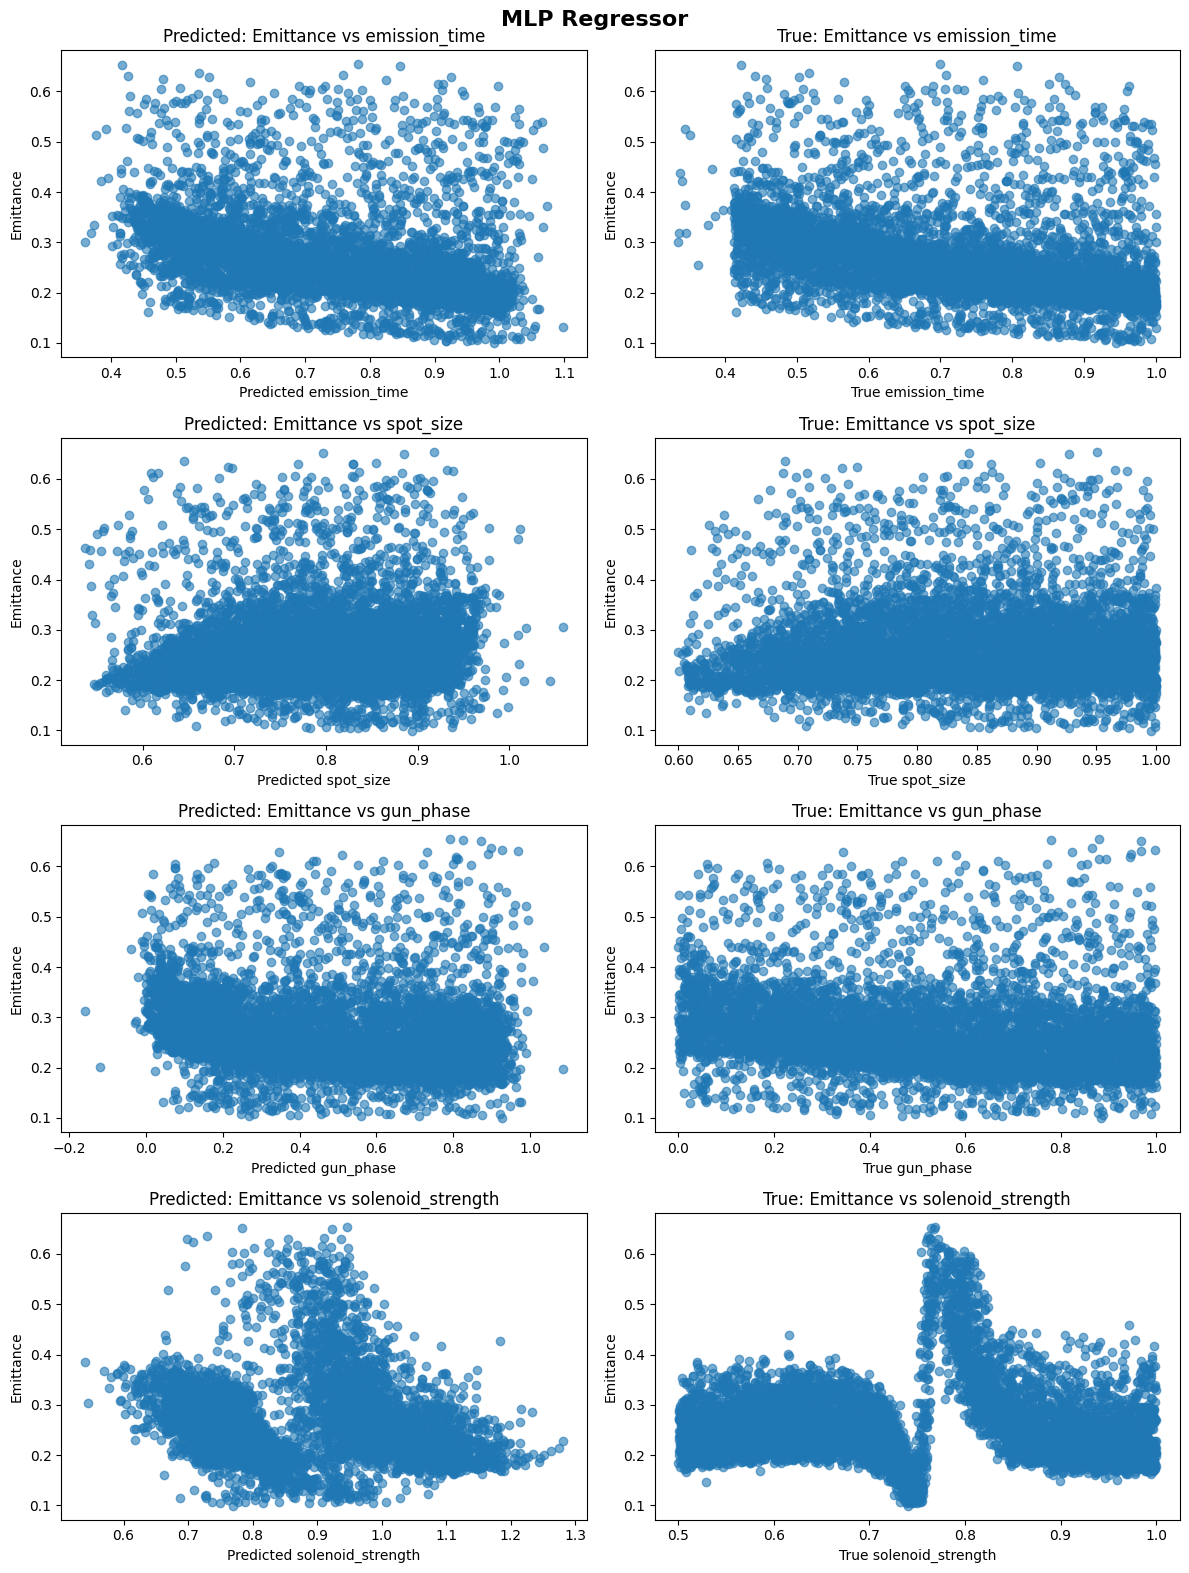

In [26]:
# Define target variables
target_variables = ['emission_time', 'spot_size', 'gun_phase', 'solenoid_strength']

# Create a figure with subplots (4 rows, 2 columns)
fig, axes = plt.subplots(4, 2, figsize=(12, 16))  # Adjust figure size if needed
fig.suptitle("MLP Regressor", fontsize=16, fontweight="bold", y=0.98)  # Adjust y to position it well

# Loop over the target variables
for i, target in enumerate(target_variables):
    # Predicted values (left column)
    axes[i, 0].scatter(y_pred_mlp[:, i], weighted["weighted_eps"], alpha=0.6)
    axes[i, 0].set_title(f'Predicted: Emittance vs {target}')
    axes[i, 0].set_xlabel(f'Predicted {target}')
    axes[i, 0].set_ylabel('Emittance')

    # True values (right column)
    axes[i, 1].scatter(y_test[target], weighted["weighted_eps"], alpha=0.6)
    axes[i, 1].set_title(f'True: Emittance vs {target}')
    axes[i, 1].set_xlabel(f'True {target}')
    axes[i, 1].set_ylabel('Emittance')

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()

Nice! We can see the plots of predicted configuration values against weighted emittance on the left, and the true values against the weighted emittance on the right.

But how about comparing some metrics? Lets check MSE, R², MAE values to get a better idea about the models' preformance

In [68]:
# Initialize an empty list to store all metrics for all targets
all_metrics = []

# Define a dictionary for mapping abbreviations to full names
model_name_mapping = {
    'rf': 'RandomForest',
    'et': 'ExtraTrees',
    'mlp': 'MLP',
    'svr': 'SVR',
    'xgb': 'XGBoost',
    'gb': 'GradientBoost',
    'lgbm': 'LightGB'
}

# Loop through each target variable
for target in target_variables:
    target_idx = target_variables.index(target)  # Find the index of the target
    
    # Initialize the dictionary to store metrics for the current target
    metrics_dict_per_target = {'Model': [], 'MSE': [], 'RMSE': [], 'R2': [], 'MAE': []}
    
    # Loop through each model
    for model in model_columns:
        # Access the correct prediction variable dynamically using globals()
        y_pred = globals().get(f'y_pred_{model}', None)
        
        # Check if y_pred is None (model might not have predictions)
        if y_pred is None:
            print(f"Warning: Prediction for model '{model}' not found!")
            continue
        
        # Extract true values (y_true) for the current target
        y_true = y_test.iloc[:, target_idx].values
        
        # If y_pred is a DataFrame, use .iloc to index it
        if isinstance(y_pred, pd.DataFrame):
            y_pred_target = y_pred.iloc[:, target_idx].values
        else:
            y_pred_target = y_pred[:, target_idx]
        
        # Calculate the metrics for the current target and model
        mse, rmse, r2, mae = calculate_metrics_for_target(y_true, y_pred_target)
        
        # Store the metrics for the current model and target
        metrics_dict_per_target['Model'].append(model)
        metrics_dict_per_target['MSE'].append(mse)
        metrics_dict_per_target['RMSE'].append(rmse)
        metrics_dict_per_target['R2'].append(r2)
        metrics_dict_per_target['MAE'].append(mae)
    
    # Convert the metrics dictionary to a DataFrame
    target_metrics_df = pd.DataFrame(metrics_dict_per_target)
    
    # Replace the model abbreviations with full names
    target_metrics_df['Model'] = target_metrics_df['Model'].replace(model_name_mapping)
    
    # Reset index to remove the old index
    target_metrics_df.reset_index(drop=True, inplace=True)
    
    # Add the target's title to the list
    target_title = f"{target}"
    
    # Display table with formatted borders and bold column names
    print(f"\n{target_title}\n")
    
    # Convert the DataFrame to a list of lists for tabulate
    table_data = target_metrics_df.values.tolist()
    column_names = [f"\033[1m{col}\033[0m" for col in target_metrics_df.columns]  # Bold column names
    
    # Print the table with borders and bold column names
    print(tabulate(table_data, headers=column_names, tablefmt="fancy_grid", showindex=False))
    
    # Print a blank line after each table for spacing
    print("\n")



emission_time

╒═══════════════╤═════════════╤═══════════╤══════════╤════════════╕
│ Model         │         MSE │      RMSE │       R2 │        MAE │
╞═══════════════╪═════════════╪═══════════╪══════════╪════════════╡
│ RandomForest  │ 0.000202964 │ 0.0142466 │ 0.992825 │ 0.00860336 │
├───────────────┼─────────────┼───────────┼──────────┼────────────┤
│ ExtraTrees    │ 0.000140839 │ 0.0118676 │ 0.995021 │ 0.00727857 │
├───────────────┼─────────────┼───────────┼──────────┼────────────┤
│ GradientBoost │ 0.000580918 │ 0.0241022 │ 0.979463 │ 0.0176081  │
├───────────────┼─────────────┼───────────┼──────────┼────────────┤
│ XGBoost       │ 0.000180685 │ 0.0134419 │ 0.993612 │ 0.00919152 │
├───────────────┼─────────────┼───────────┼──────────┼────────────┤
│ LightGB       │ 0.000180959 │ 0.0134521 │ 0.993603 │ 0.00946654 │
├───────────────┼─────────────┼───────────┼──────────┼────────────┤
│ SVR           │ 0.002172    │ 0.0466047 │ 0.923213 │ 0.0383403  │
├───────────────┼─────────────┼─

It seems like overall Extra Trees regressor might be performing better than other models. Random Forest would be the second best, also good at predicting the system configurations close to the true values.
SVR and MLP on the other hand seem to show high values for errors. Grarient boosting, XGBoost and Light gradient boosting show mixed results.